## Imports

In [1]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.4.2


## Configuration

In [2]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 10

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


In [3]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [4]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

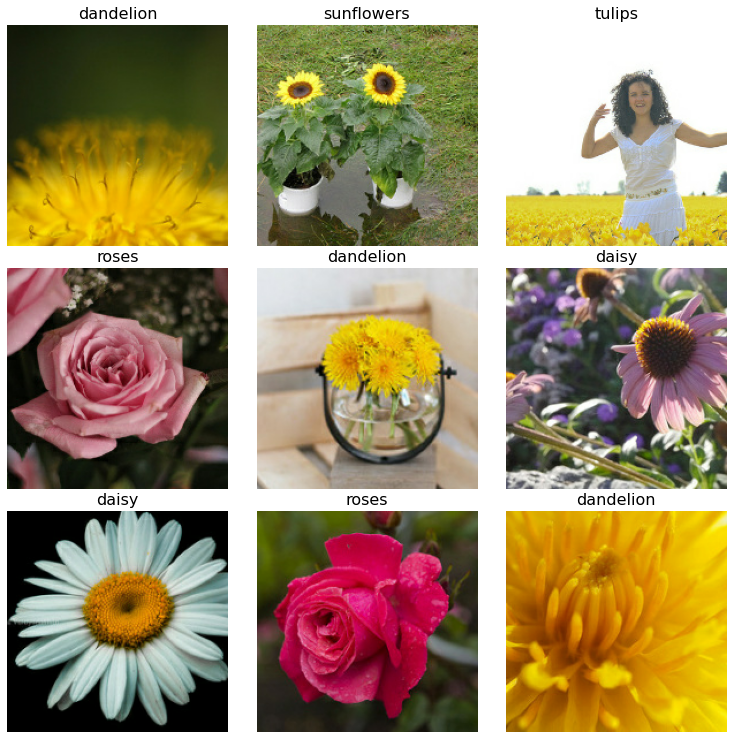

In [5]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [6]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

## Model [WORK WAS REQUIRED HERE]

In [7]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

### QUESTION 1.
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 46080)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 230405    
Total params: 2,488,389
Trainable params: 230,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Training

In [ ]:
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)

Epoch 1/10
45/46 [============================>.] - ETA: 2s - loss: 2.5634 - accuracy: 0.6520

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predictions

In [ ]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

In [ ]:
display_9_images_with_predictions(flowers, predictions, labels)